## Clustering Statistics

This notebook demonstrates how to calculate the 2-point clustering statistics from DESI data. To generate the window power spectrum, the following are required:
- Number of random mocks: ELG: 10; LRG: 8 ;QSO: 4 (clustering.ran.fits)
- One data file. (clustering.dat.fits)

This notebook also provides how to train the emulators and use the profiler. 

The power spectrum is calculated with`compute_pk.sh`, using the `cosmodesi` environment and the `pkrun.py` to compute the power spectrum.

In [1]:
# loading the desilike enviroment
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, FOLPSRCTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import plotting
from desilike import setup_logging
setup_logging()

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

2024-10-23 00:17:51.044193: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [51]:
# the tracers for DESI mocks
tracers = {
    'ELG_lowz': {
        'tracer': 'ELG_LOPnotqso',
        'zmin': 0.8,
        'zmax': 1.1,
        'zeff': 0.98,
        'ran_mock_num': '10'
    },
    'ELG_highz': {
        'tracer': 'ELG_LOPnotqso',
        'zmin': 1.1,
        'zmax': 1.6,
        'zeff': 1.325,
        'ran_mock_num': '10'
    },
}

In [ ]:
# vairables for pk calculation
No = 1
tracer_type = 'ELG_lowz' # 'ELG_lowz', 'ELG_highz', 
region = "GCcomb"  # NGC, SGC or GCcomb

if tracer_type in tracers:
    settings = tracers[tracer_type]
    tracer = settings['tracer']
    zmin = settings['zmin']
    zmax = settings['zmax']
    zeff = settings['zeff']
    ran_mock_num = settings['ran_mock_num']
else:
    raise ValueError(f"Unknown ztype: {tracer_type}")
    
# data_fn = os.path.join(os.environ['SCRATCH'], f"./altmtl{No}/mock{No}/")
pk_dir = os.path.join(os.environ['SCRATCH'], f"altmtl{No}/data{No}/pk/")
# pk_dir = os.path.join(os.environ['HOME'], "project_rc/main/data/pk/")
output_dir = '/global/homes/s/shengyu/project_rc/main/results'
cov_dir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'

# load the pk file, the pk calculated from the pkrun.py
pk_fn = pk_dir+f'pkpoles_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05.npy'
wmatrix_fn = pk_dir+f'wmatrix_smooth_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05.npy'

# load the covariance matrix from the Ezmocks
cov_fns = []
cov_fn = f'pkpoles_ELG_LOP_{region}_z{zmin}-{zmax}_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'
for i in range(100, 200):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))

In [53]:
# set the k bins
kmin     = 0.02
kmax     = 0.205
binning  = 0.005
k_ev     = np.arange(kmin, kmax, binning)
klen     = len(k_ev)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}
print(k_ev)

cosmo = DESI()
template = DirectPowerSpectrumTemplate(z=zeff,fiducial='DESI')
theory = FOLPSTracerPowerSpectrumMultipoles(template=template)
print(theory.varied_params)
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                     klim=klim, 
                                                     covariance = cov_fns,
                                                     theory=theory,
                                                     kin=np.arange(0.001, 0.35, 0.002),
                                                     wmatrix=wmatrix_fn)
likelihood = ObservablesGaussianLikelihood(observable)
likelihood()

[0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075
 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12  0.125 0.13  0.135
 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175 0.18  0.185 0.19  0.195
 0.2  ]


ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2'])
[000004.21] [0/1] 10-23 00:06  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/altml0/data0/pk/pkpoles_ELG_LOPnotqso_GCcomb_1.1_1.6_default_FKP_lin_thetacut0.05.npy'].
[000004.26] [0/1] 10-23 00:06  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global

Array(-116.63907275, dtype=float64)

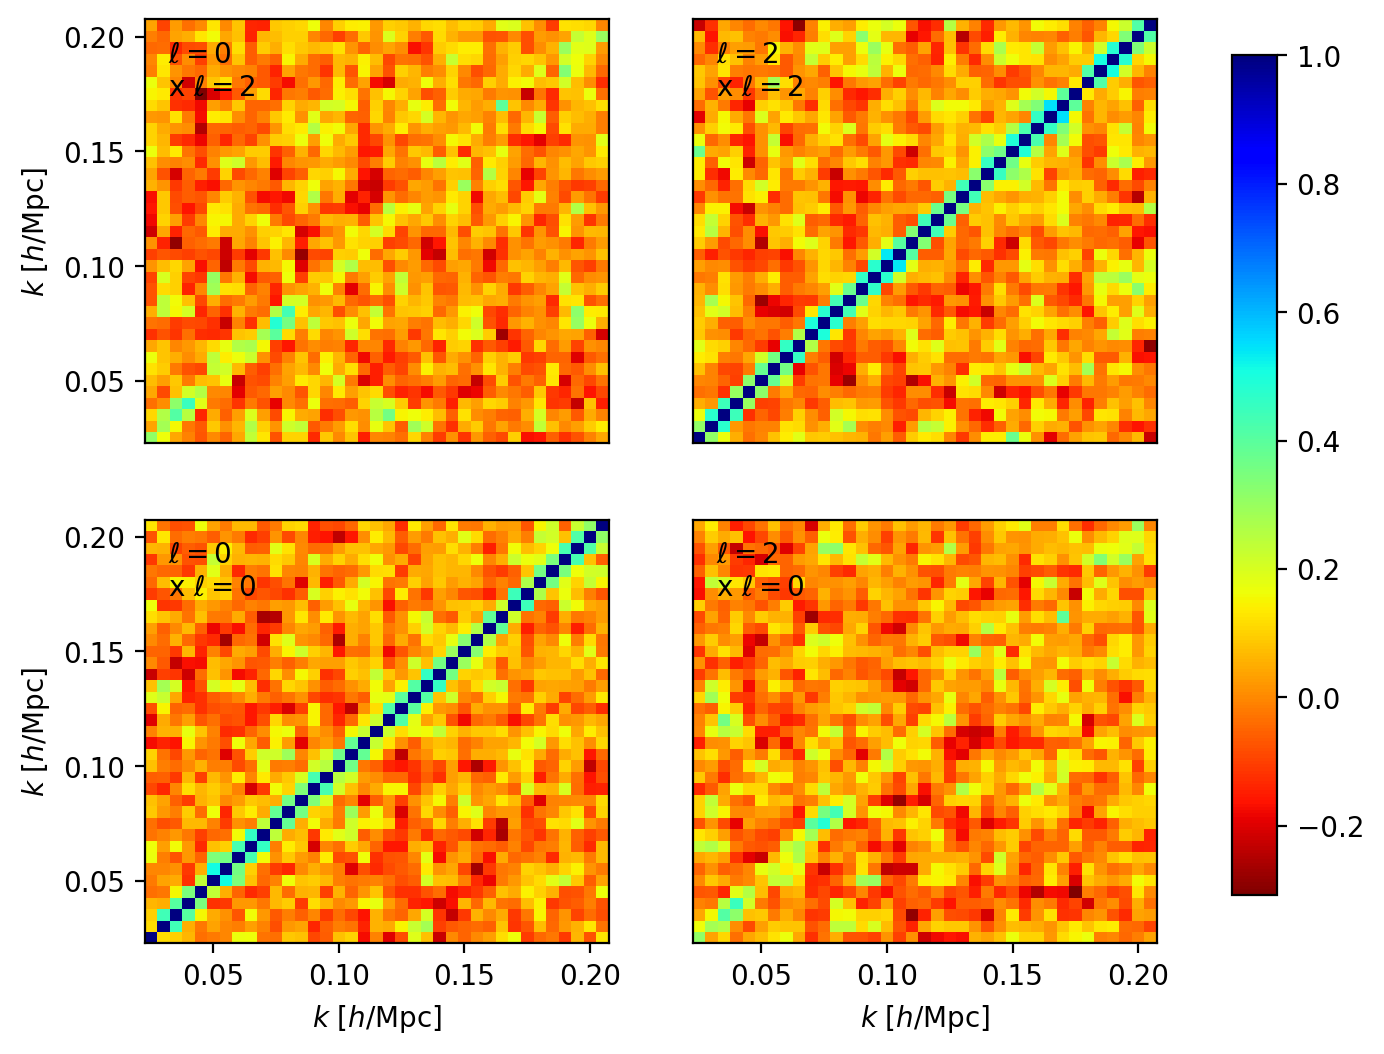

In [54]:
fig_cov = observable.plot_covariance_matrix()

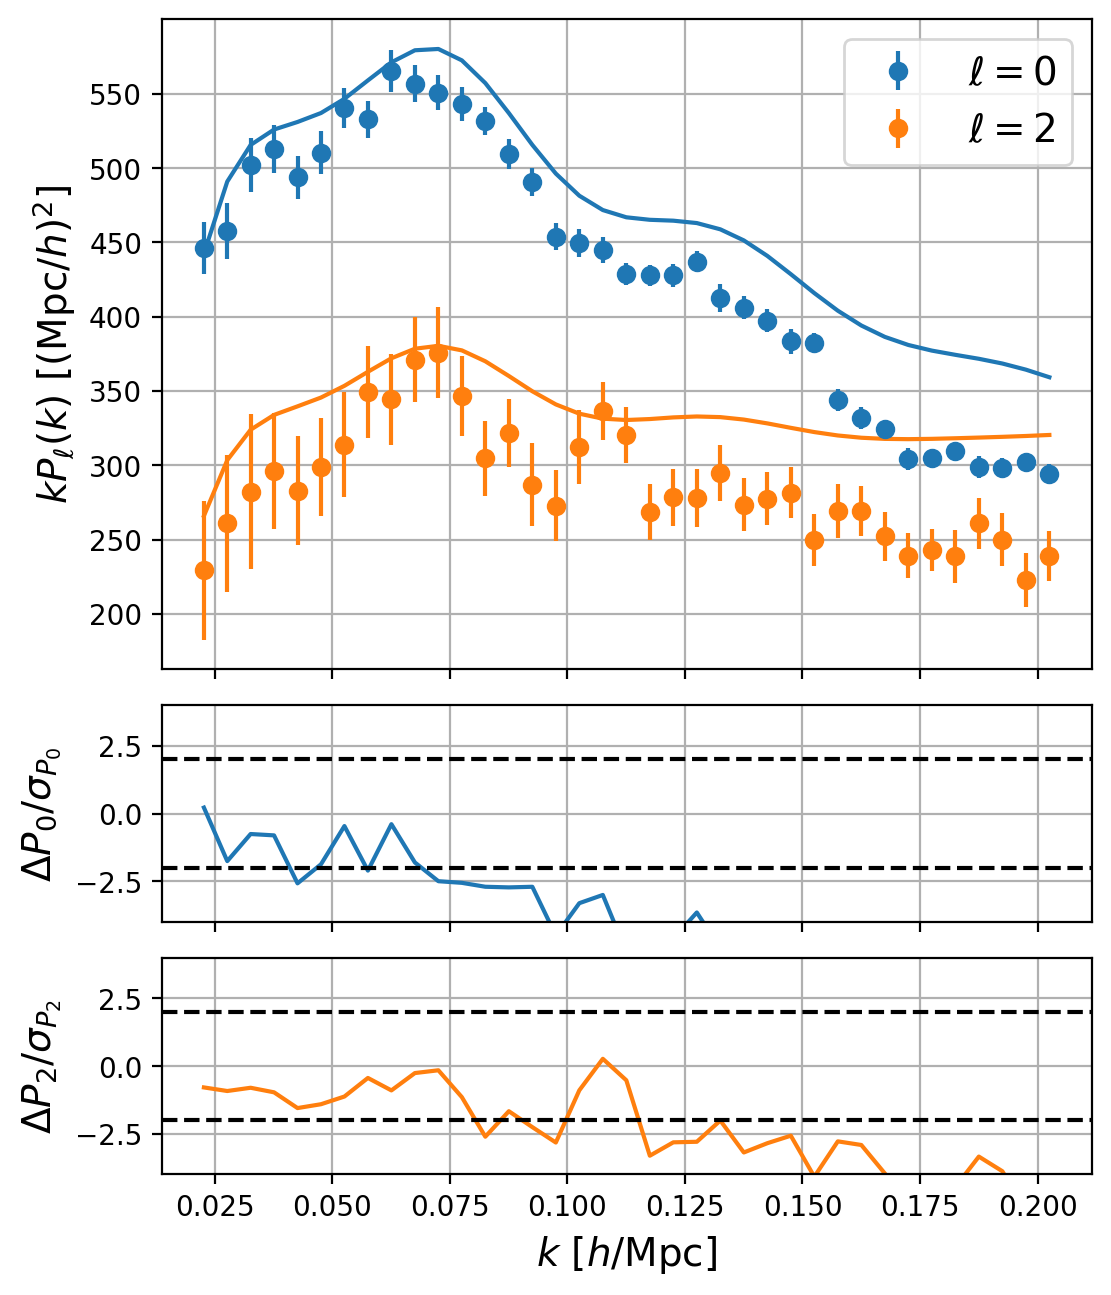

In [55]:
fig_pk = observable.plot()

In [56]:
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine

cosmology = 'LCDM' #LCDM, nuCDM, wCDM
theory_model = 'FOLPS'  # TNS, FOLPS, FOLPSRC
emulator_fn = f'./results/emulators/emulator_{cosmology}_z{zeff}_{theory_model}.npy'

def initialize_template(redshift, cosmology):
    cosmo = DESI()
    template = DirectPowerSpectrumTemplate(z=redshift, fiducial='DESI')
    if cosmology == 'nuCDM':
        template.init.params['m_ncdm'].update(fixed=False, latex=r'M_\nu', prior = {'limits': [0.0,1.0]})
    elif cosmology == 'nsCDM':
        template.init.params['n_s'].update(fixed=False)
    elif cosmology == 'wCDM':
        template.init.params['w0_fld'].update(fixed=False)
    return template

# os.remove(emulator_fn)
if not os.path.exists(emulator_fn):
    cosmo = DESI()
    template = initialize_template(zeff, cosmology)
    if theory_model =='FOLPS':
        theory = FOLPSTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    elif theory_model =='FOLPSRC':
        theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    print(theory.varied_params)
    # footprint = BoxFootprint(volume=1e10, nbar=1e-3)
    # covariance = ObservablesCovarianceMatrix(cov_fns, footprints=footprint)()
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory = theory,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)
    likelihood = ObservablesGaussianLikelihood(observable)
    likelihood()
    emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
    emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
    emulator.fit()
    emulator.save(emulator_fn)
    print("Training emmulator finished")

In [57]:
theory_el = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn), k=k_ev)
print(theory_el(h = 0.7))

[000022.45] [0/1] 10-23 00:06  Emulator                  INFO     Loading ./results/emulators/emulator_LCDM_z1.325_FOLPS.npy.
[[ 3741.48821252  9882.03486407 14520.96519464 17942.82045604
  20385.78513659 22034.82207667 23035.41155025 23507.76497984
  23553.78366554 23261.86813932 22708.47620735 21962.70518201
  21084.92525314 20127.09649293 19132.98433623 18138.21876574
  17171.52058887 16253.31100698 15398.41784488 14616.41804224
  13910.8269826  13281.97591027 12727.26459965 12241.08824738
  11816.8868303  11445.99842162 11120.35067673 10830.35100969
  10567.02319729 10322.11308125 10087.68599541  9857.14934886
   9624.92890894  9386.84153731  9139.80832935  8882.7742253
   8615.28489462  8338.15566903  8053.84385315  7764.88811623
   7474.43404312  7186.06685448  6903.24191451  6629.34605223
   6367.40350941  6119.57793637  5887.85718366  5674.09261597
   5478.71991948  5301.254932    5141.79675911  5000.09954947
   4874.41846035  4762.73986705  4663.59575808  4575.37444008
   4495

In [ ]:
from desilike.profilers import MinuitProfiler
from desilike.samples import Profiles

profile_fn = f'./results/profiles/{cosmology}/profile_{tracer}_{No}_{region}_z{zeff}.npy'   
 
# if os.path.exists(profile_fn): 
#     os.remove(profile_fn)  
if not os.path.exists(profile_fn):
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory=theory_el,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)
    likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
    likelihood()
    profiler = MinuitProfiler(likelihood, seed=42)
    profiles = profiler.maximize()
    profiles.save(profile_fn)
    print("Profiler finished")
profiles = Profiles.load(profile_fn)
print(profiles.to_stats(tablefmt='pretty'))

[000023.14] [0/1] 10-23 00:06  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/altml0/data0/pk/pkpoles_ELG_LOPnotqso_GCcomb_1.1_1.6_default_FKP_lin_thetacut0.05.npy'].
[000023.16] [0/1] 10-23 00:06  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock160/pk/pkpoles_ELG_LOP_GCcomb_z1.1

[000042.13] [0/1] 10-23 00:07  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/altml0/data0/pk/pkpoles_ELG_LOPnotqso_GCcomb_1.1_1.6_default_FKP_lin_thetacut0.05.npy'].
[000042.15] [0/1] 10-23 00:07  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_GCcomb_z1.1-1.6_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock160/pk/pkpoles_ELG_LOP_GCcomb_z1.1

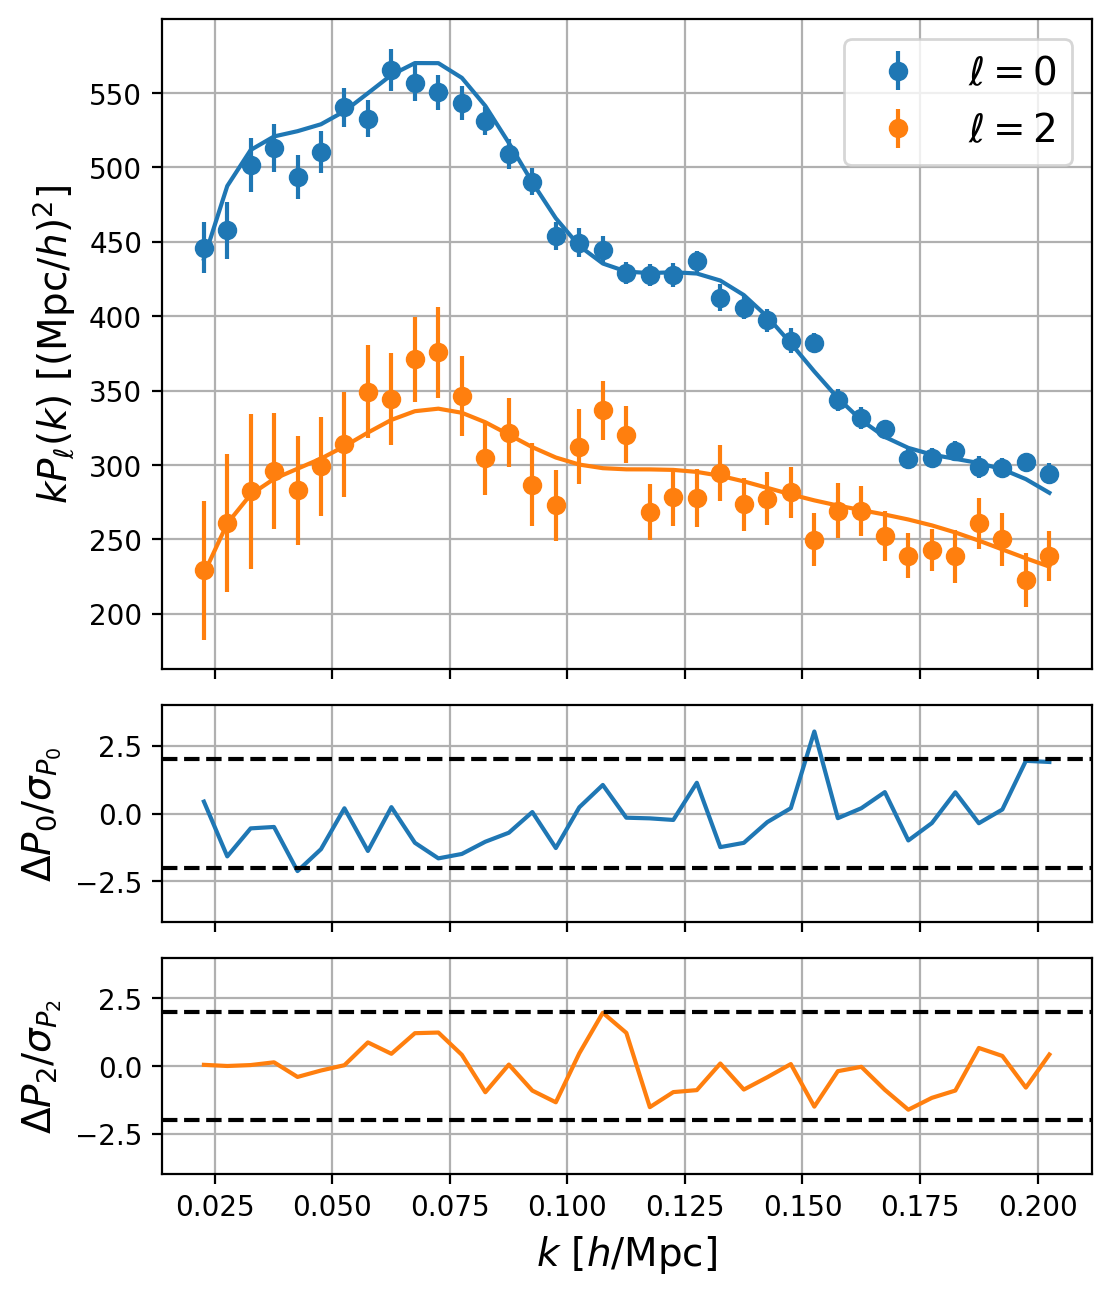

In [59]:
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                    klim=klim, 
                                                    covariance = cov_fns,
                                                    theory=theory_el,
                                                    kin=np.arange(0.001, 0.35, 0.002),
                                                    wmatrix=wmatrix_fn)
likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
print(-2*likelihood(**profiles.bestfit.choice(input=True)))
fig = observable.plot()

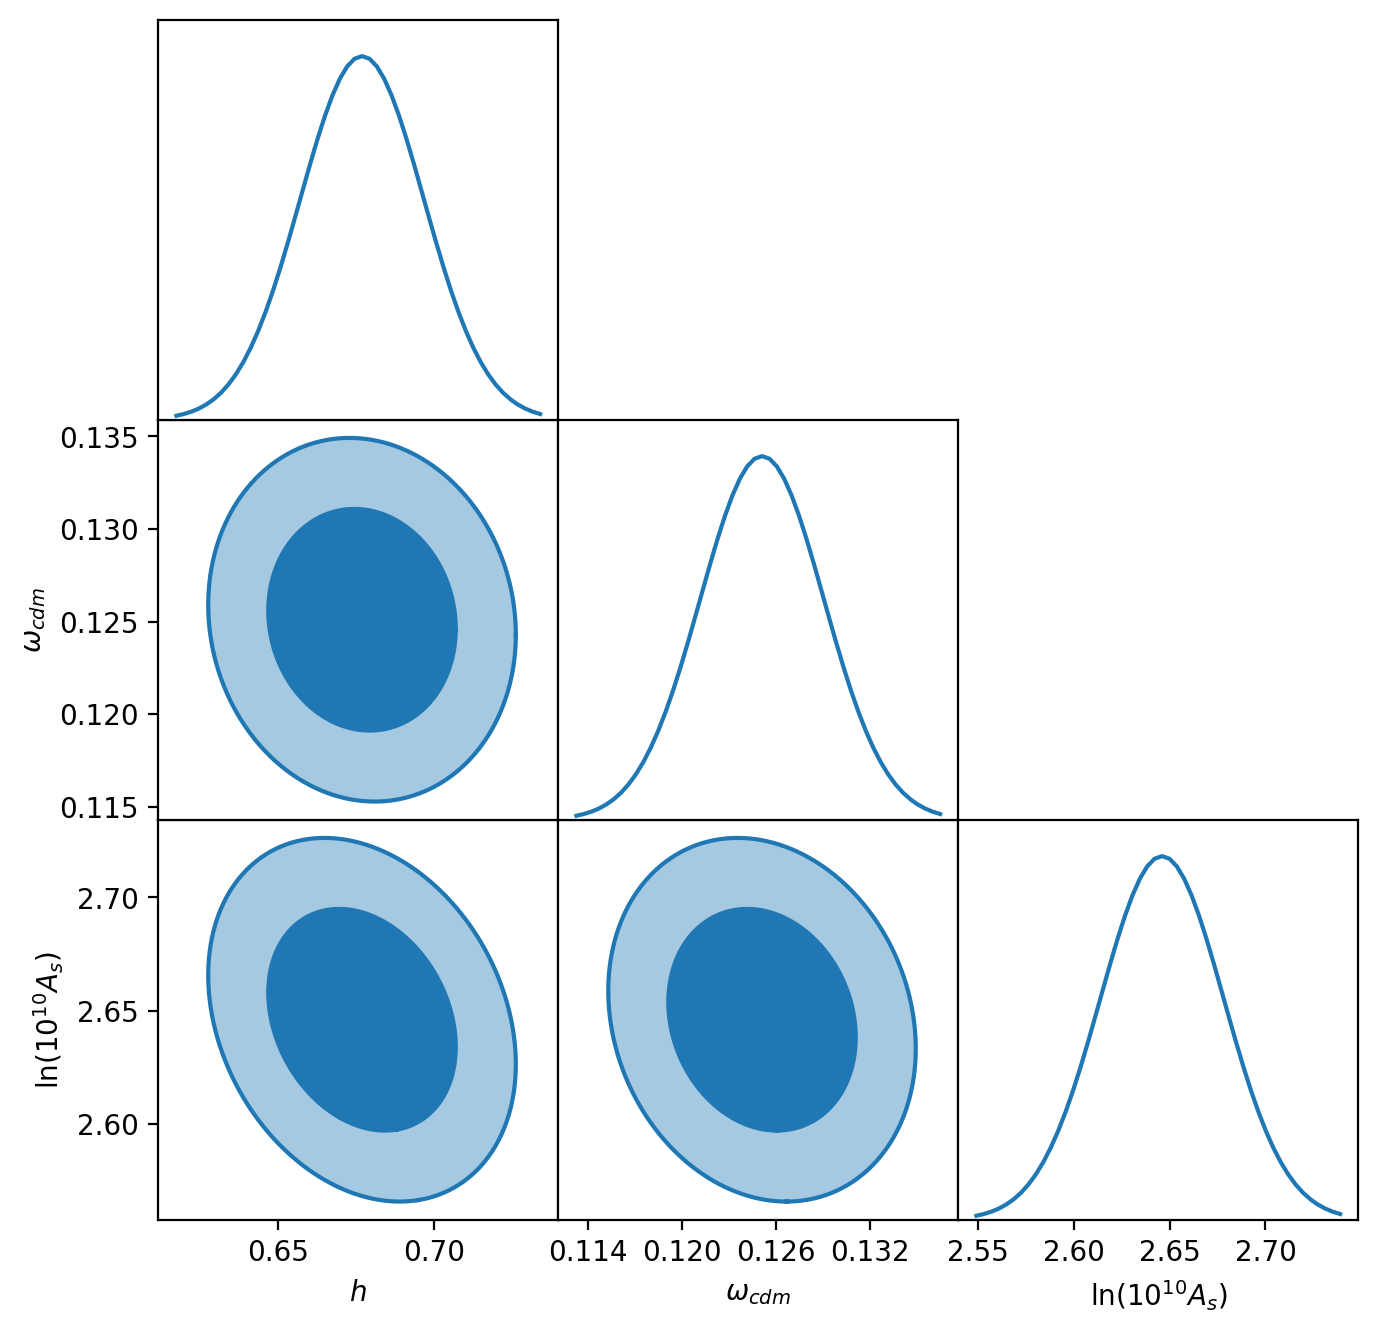

In [60]:
# plot the posterior distribution
from desilike.samples import plotting

fig = plotting.plot_triangle_contours(profiles, params=['h','omega_cdm','logA'], filled=True)
